# **CVPS20 // Working with Video Data in Python**

*November 19, 2020*

This notebook demonstrates an example of Multi-Object Tracking (MOT) with a object association algorithm that uses Kalman Filters and the Hungarian algorithm to form associations across video frames.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage.measurements as snm 
from matplotlib import animation

In [ ]:
plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"
plt.rcParams["animation.html"] = "jshtml"

We are going to need several packages that are not pre-installed on Colaboratory.  The last one is a (very slightly modified) version of the the `sort` (Simple Online and Realtime Tracking) [package](https://github.com/abewley/sort).  The original paper is [here](https://arxiv.org/abs/1602.00763).

In [ ]:
!pip install filterpy
!pip install lap

     |████████████████████████████████| 184kB 11.2MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110450 sha256=201d10280b61f4b94d52a7155988297dc38bb5681c8e42832bcc85bbc3583aa6
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy
     |████████████████████████████████| 1.5MB 10.2MB/s 
  Created wheel for lap: filename=lap-0.4.0-cp36-cp36m-linux_x86_64.whl size=1589019 sha256=82f3cd32d72367a618534986e974fb4b44a81ea14c903ff66b24fa2109bbaaf8
  Stored in directory: /root/.cache/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built lap


Now that `sort` has been installed, let's import it.

In [ ]:
!git clone https://github.com/gdobler/sort.git

Cloning into 'sort'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 201 (delta 0), reused 0 (delta 0), pack-reused 200
Receiving objects: 100% (201/201), 1.20 MiB | 2.76 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [ ]:
cp sort/sort.py .

In [ ]:
from sort import *

### **Loading and Displaying Video**

Let's load the video which was pulled from [here](https://www.youtube.com/watch?v=Q1cjgBrxscY).

In [ ]:
# -- load the video
fname =  '/content/drive/MyDrive/cvps20/data/iss/iss_timelapse.mov'
cap = cv2.VideoCapture(fname)

In [ ]:
# -- get capture params
nfr = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
nrow = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
ncol = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

print("video is : ({0}, {1}, {2})".format(nfr, nrow, ncol))

video is : (752, 988, 1812)


In [ ]:
# -- create images container
imgs = []

# -- read in every fifth frame (and every other pixel) of the video capture
for ii in range(nfr):
  if (ii%5) == 0:
    imgs.append(cap.read()[1][::2, ::2, ::-1]/255)
  else:
    cap.read()

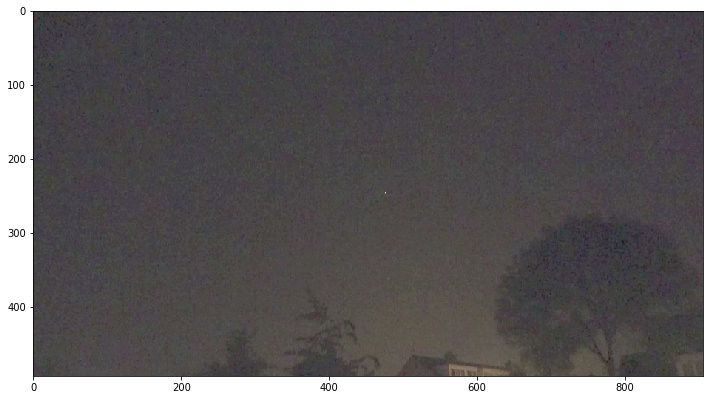

In [ ]:
# -- view the video
fig, ax = plt.subplots()
im = ax.imshow(imgs[0]**0.5)

def animate(ii):
  im.set_data(imgs[ii]**0.5)

ani = animation.FuncAnimation(fig, animate, frames=len(imgs))

In [ ]:
ani

Animation size has reached 20995825 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


### **Object Detection through Luminosity Thresholding**

We want to select the moving object in the sky.  It is significantly brighter than most pixels in the image, so we can use our old thresholding and labeling techniques,

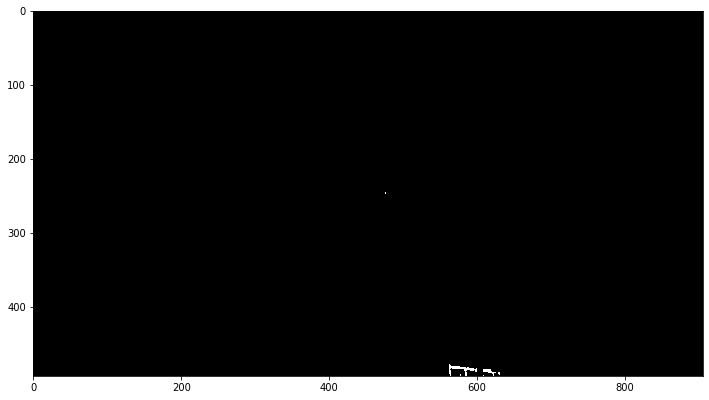

In [ ]:
# -- find an appropriate threshold
plt.imshow(imgs[0].mean(axis=-1) > 0.2)


In [ ]:
# -- let's get the detections
thr = 0.2
dets = []

for img in imgs:
  timg = img.mean(axis=-1) > thr
  labs, nlabs = snm.label(timg)
  com = np.array(snm.center_of_mass(timg, labs, range(1, nlabs+1)))
  dets.append(com)


In [ ]:
len(dets)

In [54]:
pnts.set_offsets?

In [ ]:
dets[3].shape

Let's visualize our detections so that we're capturing the ISS in each frame,

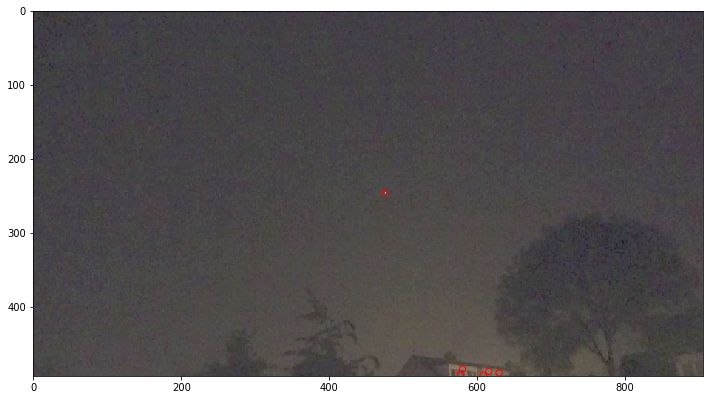

In [ ]:
# -- visualize detections
fig, ax = plt.subplots()
im = ax.imshow(imgs[0])
pnts = ax.scatter(dets[0][:,1], dets[0][:, 0], facecolor = 'none', edgecolors='red', s=40)

def animate(ii):
  im.set_data(imgs[ii]**0.5)
  pnts.set_offsets(dets[ii][:, :: -1])

ani = animation.FuncAnimation(fig, animate, frames=len(imgs))

In [ ]:
ani

Output hidden; open in https://colab.research.google.com to view.

### **Object Tracking through Detection Associations**

And now we associate those detections,

In [26]:
# -- initialize the tracker
mot = Sort()

In [28]:
# -- create bounding boxes (w/ scores = 1)
wid = 5
det_bb = []

for det in dets:
  oarr = np.ones((det.shape[0], 1))
  tbb = np.concatenate((det - wid, det + wid, oarr), axis=1)
  det_bb.append(tbb)

In [30]:
# -- link detections (using a "list comprehension")
tracks = [mot.update(i) for i in det_bb]


Group track IDs together into a "dictionary"


In [41]:
# -- gat all unique track IDs
all_ids = []

for track in tracks:
  for obj in track:
    all_ids.append(obj[4])

uids = np.unique(all_ids)

In [44]:
# -- initialize dictionary
trackd = {}
for uid in uids:
  trackd[uid] = []

In [45]:
# -- append location
for track in tracks:
  for obj in track:
    trackd[obj[4]].append([obj[0] + wid, obj[1] + wid])

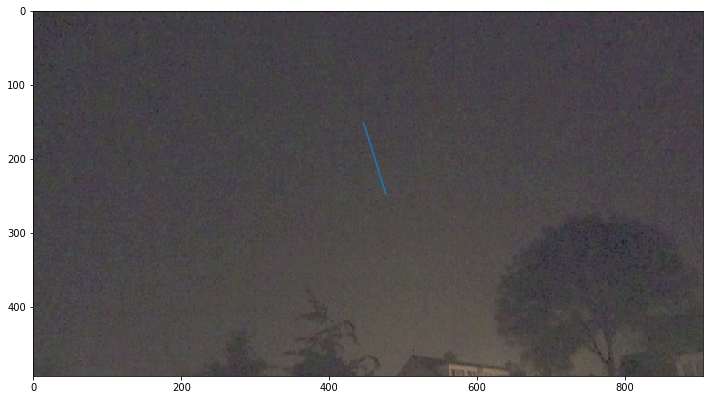

In [53]:
# -- now plot them
fig, ax = plt.subplots()

for uid in uids:
  if len(trackd[uid]) > 100:
    pos = np.array(trackd[uid])
    ax.plot(pos[:, 1], pos[:, 0])

ax.imshow(imgs[0]**0.5)
fig.show()